In [1]:
import numpy as np
import cv2, random, sys, os, glob
from itertools import chain

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
from shutil import copyfile
copyfile(src = "../input/facedataset/FUNC_script.py", dst = "../working/FUNC_script.py")
from FUNC_script import *

In [3]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

### CONFIG

In [4]:
%%capture

totalSubjects= 5
mask= load_img('../input/facedataset/binary_glass_mask2.jpg')/255
imgDir= '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/'
# Load FaceNet Model
model = load_model('../input/face-net-keras-model/facenet_keras.h5', compile= False)
model.trainable= False

# (index(0)==legitimate)
# (index((totalSubjects-1))== Adversarial)
subjects= ['s12', 's33', 's27', 's06', 's01'] #['s33', 's12', 's27', 's06', 's26']
subjectLabels=[]
subjectsDict= {k:[] for k in subjects}
target= subjects[0]

2022-04-04 03:58:07.998317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 03:58:08.126506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 03:58:08.127204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 03:58:08.128342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
totSample=0
for sam in subjects:
    for path in glob.glob(imgDir+sam+'/*'):
        img= load_img(path, resize=160)
        img= model.predict(img[np.newaxis, :, :, :]/255.0)[0]
        subjectsDict[sam].append(img)
        subjectLabels.append(subjects.index(sam))
        totSample+=1
totSample

2022-04-04 03:58:14.470932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-04 03:58:17.150937: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50

In [6]:
flattened = np.array([val for sublist in list(subjectsDict.values()) for val in sublist])

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)

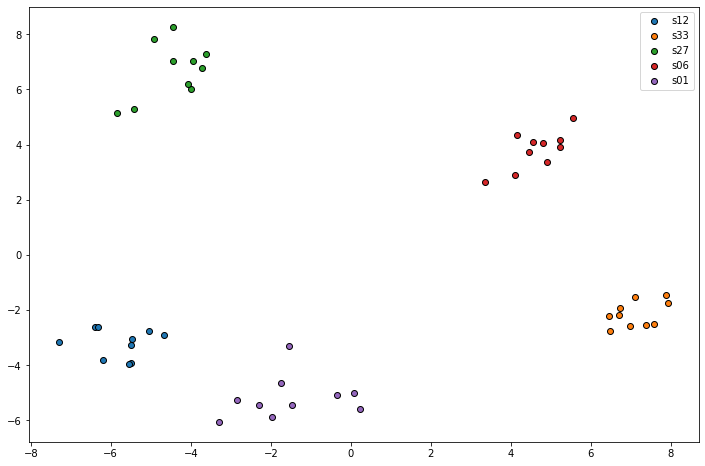

In [7]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [8]:
flattened.shape, len(subjectLabels)

((50, 128), 50)

In [9]:
totalSubjects

5

In [10]:
from sklearn.cluster import KMeans
class kMeansModel:
    def __init__(self, n_class):
        self.n_class=n_class
        self.model= KMeans(n_clusters=self.n_class, random_state=0)
    def fit(self, data):
        self.model.fit(data)
        self.centers= self.model.cluster_centers_
        return self.model.labels_
    def predict(self, data, th=15):
        res=[]
        for d in data:
            arr= np.linalg.norm(self.centers-d, axis=1)
            #print(arr)
            if arr.min()<=th:
                ind= np.where(arr==arr.min())[0][0]
                res.append(ind)
            else:
                res.append(-1)
        return np.array(res)        

In [11]:
KMEANS= kMeansModel(totalSubjects)
KMEANS.fit(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

### Adversarial Centroid

In [12]:
# Data  Loading
def load_data(path):
    X=[]
    for i, sample in enumerate(path):
        image= load_img(sample)
        image = cv2.resize(image, (160, 160))
        X.append(image/255.0)
    return np.array(X)

# Loss
def loss_object(pred, label, delta):
    # Loss= euclidean distance + Delta_x pixel Variance
    dist= Euclidean_dist(pred, label)
#     print(dist)
#     print(tf.norm(label - pred, axis=-1))
    variance= Sample_variance(delta)
    Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
    return Loss

def back_propagate(model, X, mask, delta_x, Xc):
    with tf.GradientTape() as g:
        g.watch(delta_x)
        X_batch= Generate_sample(X, delta_x, mask)
        feature= model(X_batch)
        loss= loss_object(pred= feature, label= Xc, delta= delta_x)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = g.gradient(loss, delta_x)
    return gradient, tf.reduce_mean(loss).numpy()

In [13]:
# tragetImages= load_data(glob.glob(imgDir+target+'/*'))
# tragetFeature= model.predict(tragetImages)

advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
advFeature= model.predict(advImages)
Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
advRefFeature= Generate_target(advFeature[3], batch_size=advImages.shape[0])
advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 160, 160, 3), (10, 128), (10, 128))

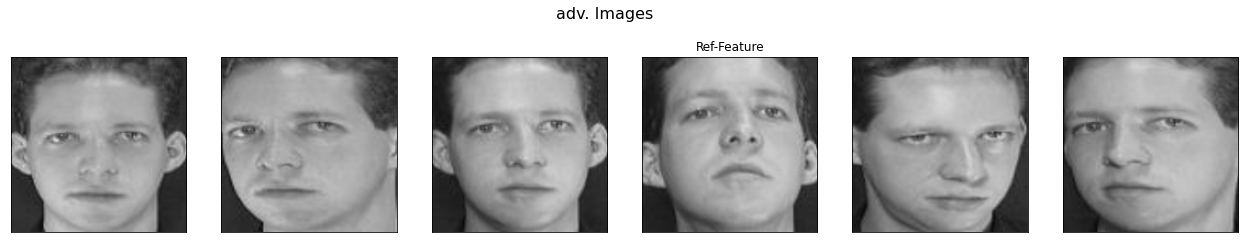

In [14]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [15]:
Delta.shape

(10, 160, 160, 3)

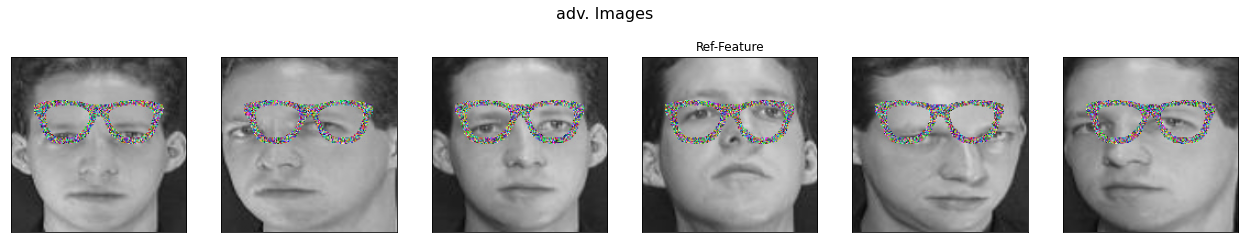

In [16]:
advImagesShow= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [17]:
# Tf Variables
advImages= tf.Variable(advImages, dtype=tf.float64)
Delta= tf.Variable(Delta, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
advRefFeature= tf.Variable(advRefFeature)

In [18]:
epoch= 400
Lambda= 0.2
for ep  in range(epoch+1):
    grad, loss= back_propagate(model, advImages, mask, Delta, advRefFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%10 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 172.043
Epoch: 10   Loss: 158.374
Epoch: 20   Loss: 147.211
Epoch: 30   Loss: 136.797
Epoch: 40   Loss: 126.881
Epoch: 50   Loss: 117.327
Epoch: 60   Loss: 108.130
Epoch: 70   Loss: 99.227
Epoch: 80   Loss: 90.717
Epoch: 90   Loss: 82.501
Epoch: 100   Loss: 74.560
Epoch: 110   Loss: 67.050
Epoch: 120   Loss: 59.936
Epoch: 130   Loss: 53.234
Epoch: 140   Loss: 47.081
Epoch: 150   Loss: 41.341
Epoch: 160   Loss: 36.181
Epoch: 170   Loss: 31.627
Epoch: 180   Loss: 27.580
Epoch: 190   Loss: 24.127
Epoch: 200   Loss: 21.289
Epoch: 210   Loss: 18.898
Epoch: 220   Loss: 16.915
Epoch: 230   Loss: 15.311
Epoch: 240   Loss: 13.923
Epoch: 250   Loss: 12.836
Epoch: 260   Loss: 11.950
Epoch: 270   Loss: 11.176
Epoch: 280   Loss: 10.592
Epoch: 290   Loss: 10.057
Epoch: 300   Loss: 9.684
Epoch: 310   Loss: 9.374
Epoch: 320   Loss: 9.098
Epoch: 330   Loss: 8.826
Epoch: 340   Loss: 8.611
Epoch: 350   Loss: 8.492
Epoch: 360   Loss: 8.299
Epoch: 370   Loss: 8.257
Epoch: 380   Loss: 8.060

In [19]:
subjects.append('deltaAdvCentroid')
subjectsDict['deltaAdvCentroid']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaAdvCentroid'].shape

(10, 128)

In [20]:
flattened= np.vstack((flattened, subjectsDict['deltaAdvCentroid']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(60, 2)

In [21]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

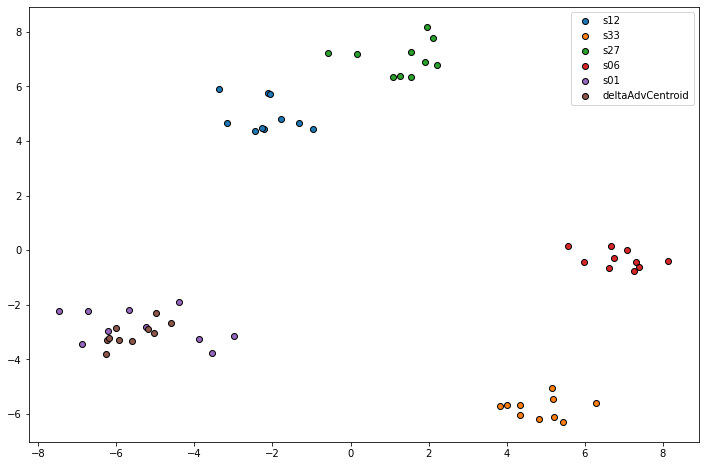

In [22]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+1):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

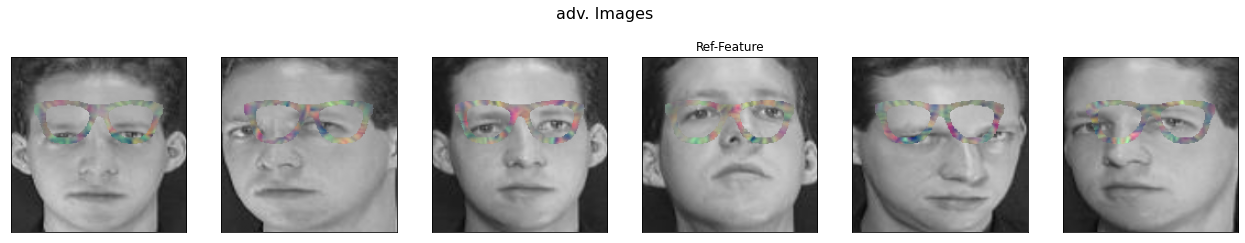

In [23]:
advImagesShow0= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

### Target Att....


In [24]:
tragetImages= load_data(glob.glob(imgDir+target+'/*'))
tragetFeature= (model.predict(tragetImages))
targetRefFeature= Generate_target(np.mean(tragetFeature, axis=0), batch_size=tragetImages.shape[0])
tragetImages.shape, tragetFeature.shape

# advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
# advFeature= model.predict(advImages)
# Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
# advRefFeature= Generate_target(advFeature[5], batch_size=advImages.shape[0])
# advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 128))

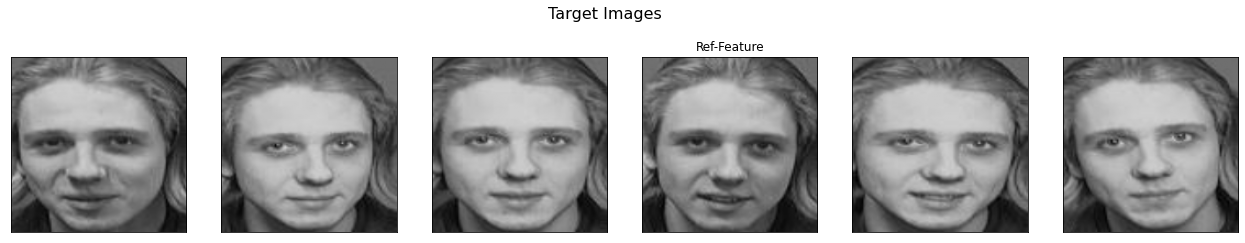

In [25]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("Target Images", size= 16)
for i in range(6):
    ax[i].imshow(tragetImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [26]:
epoch= int(400 *4.5)
Lambda= 0.014
for ep  in range(epoch):
    grad, loss= back_propagate(model, advImages, mask, Delta, tragetFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%20 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 17.469
Epoch: 20   Loss: 15.888
Epoch: 40   Loss: 14.794
Epoch: 60   Loss: 14.112
Epoch: 80   Loss: 13.621
Epoch: 100   Loss: 13.246
Epoch: 120   Loss: 12.930
Epoch: 140   Loss: 12.665
Epoch: 160   Loss: 12.454
Epoch: 180   Loss: 12.280
Epoch: 200   Loss: 12.127
Epoch: 220   Loss: 11.993
Epoch: 240   Loss: 11.876
Epoch: 260   Loss: 11.776
Epoch: 280   Loss: 11.690
Epoch: 300   Loss: 11.615
Epoch: 320   Loss: 11.548
Epoch: 340   Loss: 11.488
Epoch: 360   Loss: 11.432
Epoch: 380   Loss: 11.379
Epoch: 400   Loss: 11.329
Epoch: 420   Loss: 11.284
Epoch: 440   Loss: 11.241
Epoch: 460   Loss: 11.200
Epoch: 480   Loss: 11.160
Epoch: 500   Loss: 11.124
Epoch: 520   Loss: 11.089
Epoch: 540   Loss: 11.056
Epoch: 560   Loss: 11.024
Epoch: 580   Loss: 10.994
Epoch: 600   Loss: 10.966
Epoch: 620   Loss: 10.938
Epoch: 640   Loss: 10.911
Epoch: 660   Loss: 10.886
Epoch: 680   Loss: 10.863
Epoch: 700   Loss: 10.840
Epoch: 720   Loss: 10.818
Epoch: 740   Loss: 10.797
Epoch: 760   Loss:

In [27]:
subjects.append('deltaTarget')
subjectsDict['deltaTarget']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaTarget'].shape

(10, 128)

In [28]:
flattened= np.vstack((flattened, subjectsDict['deltaTarget']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(70, 2)

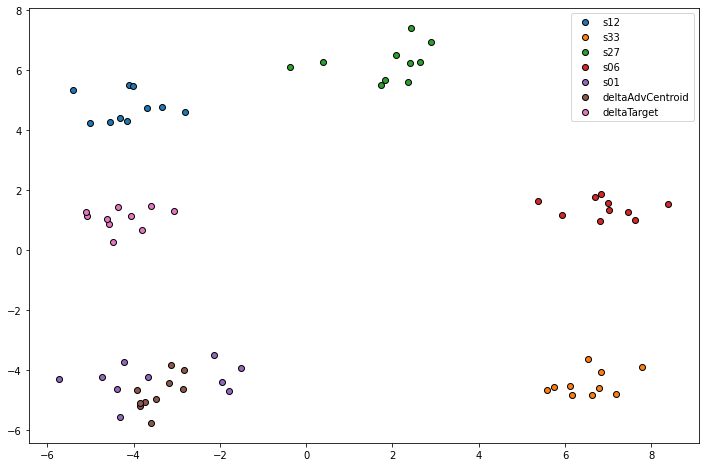

In [29]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+2):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [30]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

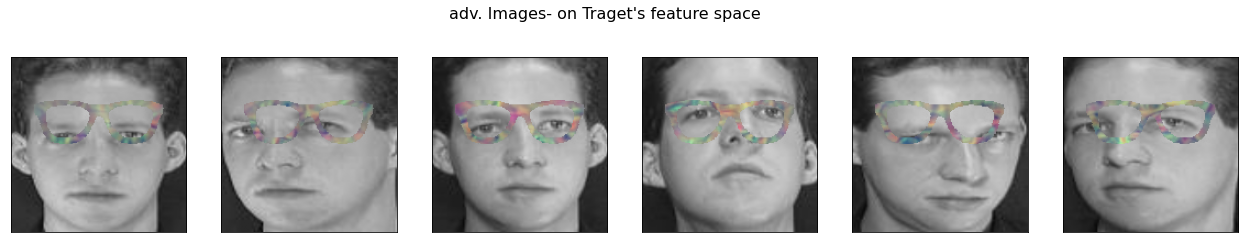

In [31]:
advImagesShow1= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images- on Traget's feature space", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow1[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()

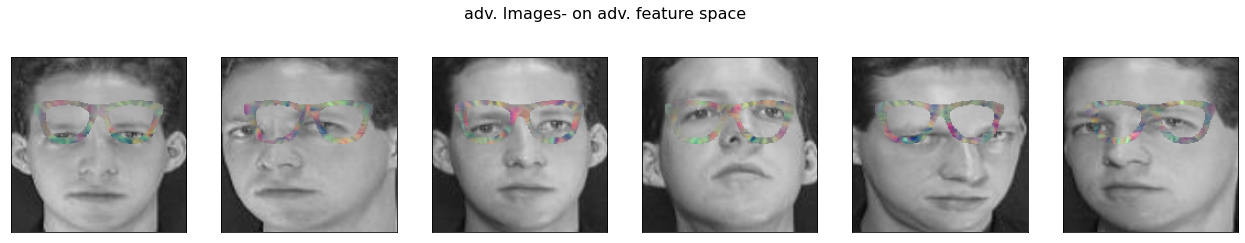

In [32]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images- on adv. feature space", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()